# Continuous Efficiency

For most of our analyses, we have been investigating the relationships between various conditions and our lap efficiency (J/m). We have investigated both real efficiency which relates to the actual distance travelled, and practical/effective efficiency which relates to the recorded distance by competition, based on the track length.

I noticed, however, that real efficiency can also be obtained at an instant in time, given by
$$e_{real}(t) = \frac{P_{motor}(t)}{|V(t)|}\,.$$

This instantaneous value should relate simply to lap real efficiency, which would be the average value of $e_{real}$ over the lap.

Based on this, I present below a plot of real-time efficiency, as well as the trends within a lap.

In [1]:
from data_tools import TimeSeries, DBClient, FSGPDayLaps
import matplotlib.pyplot as plt
import numpy as np
import datetime

data_client = DBClient("can_log_prod")

Creating client with API Token: s4Z9_S6_O09kDzYn1KZcs7LVoCA2cVK9_ObY44vR4xMh-wYLSWBkypS0S0ZHQgBvEV2A5LgvQ1IKr8byHes2LA==
Creating client with Org: 8a0b66d77a331e96


In [20]:
def lap_current_ts(start_time: datetime, end_time: datetime, client: DBClient) -> TimeSeries:
    raw_motor_current: TimeSeries = client.query_time_series(start_time, end_time, "BatteryCurrent")
    motor_current_dir: TimeSeries = client.query_time_series(start_time, end_time, "BatteryCurrentDirection")

    # Align x-axes
    raw_motor_current, motor_current_dir = TimeSeries.align(raw_motor_current, motor_current_dir)
    # Make direction -1 or 1 instead of 1 or 0
    motor_current_sign = motor_current_dir * -2 + 1

    # Account for regen direction
    motor_current = raw_motor_current.promote(raw_motor_current * motor_current_sign)
    motor_current.units = "A"
    motor_current.meta["field"] = "Motor Current (adjusted for regen)"
    return motor_current

def lap_power_ts(start_time: datetime, end_time: datetime, client: DBClient) -> TimeSeries:
    motor_voltage: TimeSeries = client.query_time_series(start_time, end_time, "BatteryVoltage")
    motor_current = lap_current_ts(start_time, end_time, client)

    # Align x-axes
    motor_voltage, motor_current = TimeSeries.align(motor_voltage, motor_current)

    motor_power = motor_current.promote(motor_current * motor_voltage)
    motor_power.units = "W"
    motor_power.meta["field"] = "Motor Power (adjusted for regen)"
    return motor_power

def lap_speed_ts(start_time: datetime, end_time: datetime, client: DBClient) -> TimeSeries:
    lap_speed: TimeSeries = client.query_time_series(start_time, end_time, "VehicleVelocity")

    lap_speed.units = "m/s"
    lap_speed.meta["field"] = "Speed"
    return lap_speed

def lap_efficiency_ts(start_time: datetime, end_time: datetime, client: DBClient) -> TimeSeries:
    speed: TimeSeries = lap_speed_ts(start_time, end_time, client)
    motor_power: TimeSeries = lap_power_ts(start_time, end_time, client)  # accounts for regen
    
    # Align x-axes
    speed, motor_power = TimeSeries.align(speed, motor_power)
    
    efficiency = speed.promote(
        np.divide(motor_power, speed, where=(speed > 0.1), out=np.zeros_like(motor_power))
    )

    efficiency.units = "J/m"
    efficiency.meta["field"] = "Instantaneous Efficiency"
    return efficiency

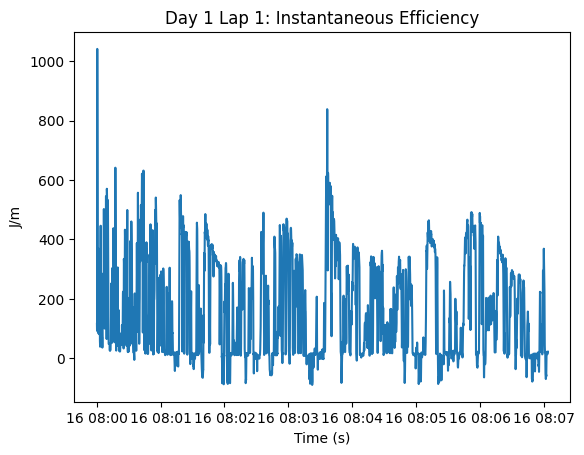

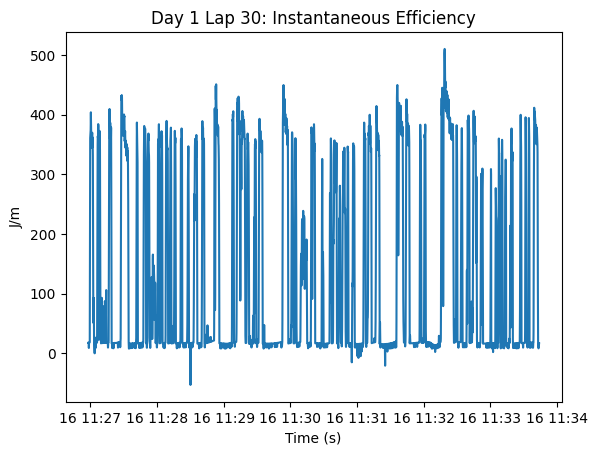

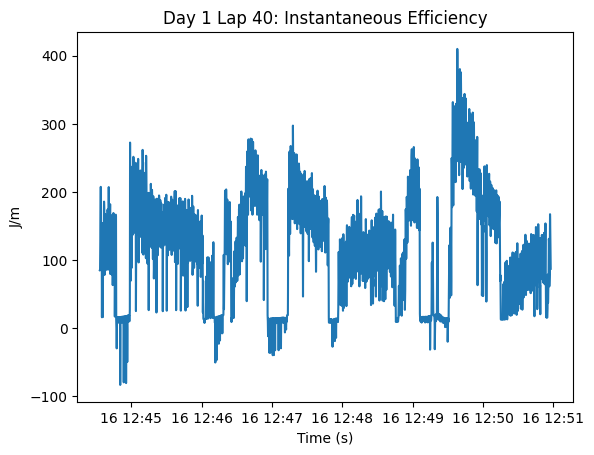

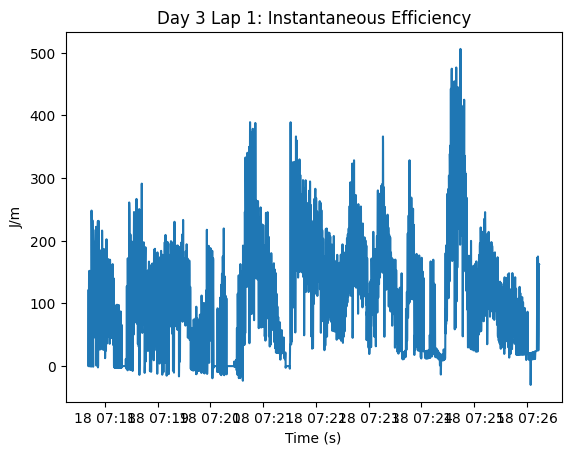

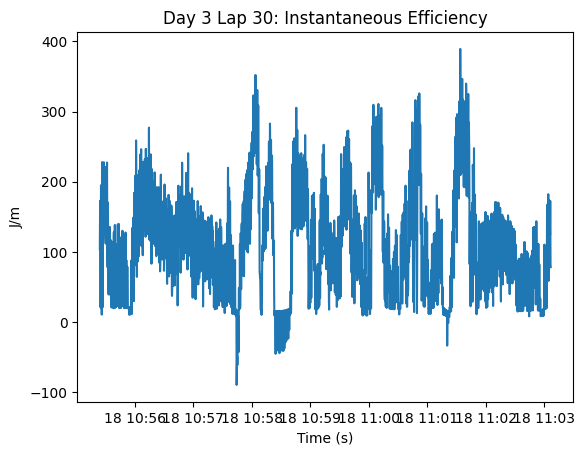

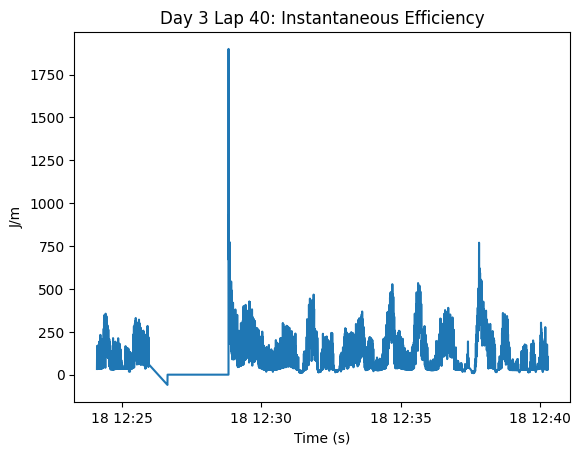

In [21]:
laps1 = FSGPDayLaps(1)  # Corresponds to July 16th
laps3 = FSGPDayLaps(3)  # Corresponds to July 18th

day_1_to_plot = (1, 30, 40)

for d1lap in day_1_to_plot:
    
    start_time = laps1.get_start_utc(d1lap)
    finish_time = laps1.get_finish_utc(d1lap)
    
    efficiency: TimeSeries = lap_efficiency_ts(start_time, finish_time, data_client)
    efficiency.meta["measurement"] = f"Day 1 Lap {d1lap}"
    efficiency.plot()
    
day_3_to_plot = (1, 30, 40)

for d3lap in day_1_to_plot:
    
    start_time = laps3.get_start_utc(d3lap)
    finish_time = laps3.get_finish_utc(d3lap)
    
    efficiency: TimeSeries = lap_efficiency_ts(start_time, finish_time, data_client)
    efficiency.meta["measurement"] = f"Day 3 Lap {d3lap}"
    efficiency.plot()


Because this instantaneous efficiency is proportional to current, we see driving style differences in the spikiness. Apart from this though, we can observe the different turns in the track as spikes appearing on each lap. While this analysis would be better in the distance domain so we know where we are on the track, we can still observe lap trends. Overall, **I don't think that instantaneous efficiency is worth too much thought**, since the velocity we are at is not a function of the behaviour at that time and is instead affected by the inertia of the car and its previous acceleration. However, in conjunction with our macro-scale data analysis across many laps, I'd like to more deeply explore trends within a lap because I believe we can gain a lot from knowing how Brightside performs under varying road geometry.